In [56]:
#based on the conversation here:
#https://twitter.com/SiamKidd/status/1913959368611029081

import requests, json
import pandas as pd
import numpy as np
import decimal
import time
from datetime import datetime, timedelta
from rich import print
import os
from dotenv import load_dotenv
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
import math 
# Load environment variables from .env file
load_dotenv()

api_key= os.getenv('taostats_api')

headers = {
            "accept": "application/json",
            "Authorization": api_key
        }
#get time in MS right now
time_end = int(time.time())
#pull data from the start of dTao
#feb 14
time_start = 1739574169

days = math.ceil((time_end - time_start)/3600/24)

In [57]:
#sometimes the chain spits out a time with milliseconds.. Sometimess it doesnt.  Its annoying.
#this fixes it. returns a datetime object
def stupid_time_fix(timestamp):
    if len(timestamp) > 20:
        date_obj = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")
    else:
        date_obj = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%SZ")
    
    return date_obj

In [46]:
#daily tao staked as alpha
#this will get us the percentage tao staked as alph and the percentage tao staked as root
staking_data = []
page =1
total_pages = 1
while page <= total_pages:
    url = f"https://api.taostats.io/api/stats/history/v1?timestamp_start={time_start}&timestamp_end={time_end}&frequency=by_day&page=1&limit=200"
    response = requests.get(url, headers=headers)

    resJson = json.loads(response.text)
    staking_data += resJson
    total_pages = resJson['pagination']['total_pages']
    page +=1

In [47]:
percent_tao_as_alpha = []
percent_tao_on_root = []
for stake in resJson['data']:
    alpha = round(float(stake['staked_alpha'])/1e9,3)
    total_staked = round(float(stake['staked'])/1e9,3)
    #alpha
    percentage = alpha/total_staked*100
    percent_tao_as_alpha.append(percentage)
    #root
    root_percentage = 100- percentage
    percent_tao_on_root.append(root_percentage)

#print(percent_tao_on_root,percent_tao_as_alpha)

In [48]:
raw_total_price_data = []
page = 1
#get sum of subnet price data
#there is one per hour - so a little math to go back to the begnning of dtao
total_pages = math.ceil(days*24/200)
print(total_pages)
while page <= total_pages:
    url = f"https://api.taostats.io/api/dtao/pool/total_price/v1?limit=200&page={page}"
    response = requests.get(url, headers=headers)
    resJson = json.loads(response.text)
    temp = resJson['data']
    raw_total_price_data += temp
    page+=1

9

In [49]:
total_price_data = []
for price in raw_total_price_data:
    time = stupid_time_fix(price['timestamp'])
    if time.hour ==23:
        ##end of day 
        total_price = float(price['price'])
        total_price_data.append(total_price)


In [50]:
print(len(total_price_data), len(percent_tao_as_alpha))

68 67

In [51]:
#all of the arrays are new -> old so let's reverse them
percent_tao_on_root = percent_tao_on_root[::-1]
percent_tao_as_alpha = percent_tao_as_alpha[::-1]

#total price data is sometimes too long - cut off the oldest, and then reverse
total_price_data = total_price_data[:len(percent_tao_as_alpha)]
total_price_data = total_price_data[::-1]


print(len(total_price_data), len(percent_tao_as_alpha))

67 67

In [52]:
price_ratio = []

counter = 0

while counter < len(percent_tao_as_alpha):
    ratio = percent_tao_as_alpha[counter]/total_price_data[counter]
    price_ratio.append(ratio)
    #print(percent_tao_as_alpha[counter],total_price_data[counter], ratio)
    counter +=1
#print(price_ratio)

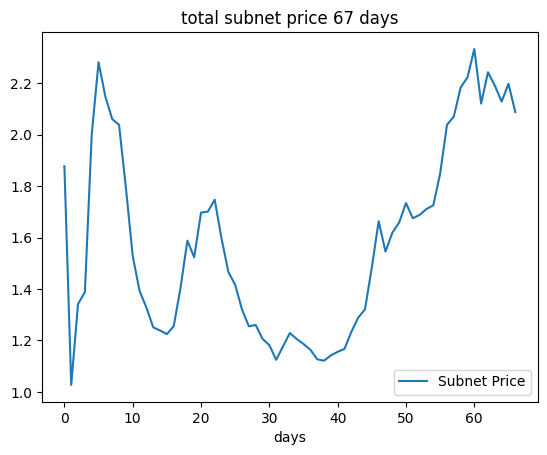

In [53]:
# Create a scatter plot
import matplotlib.pyplot as plt
#plt.scatter(range(len(reverse_price_ratio)), reverse_price_ratio, label='Price Ratio')
plt.plot(range(len(total_price_data)), total_price_data, label='Subnet Price')
#plt.scatter(range(len(percent_tao_as_alpha)), percent_tao_as_alpha, label='% tao in alpha pools')

# Add labels and title
plt.xlabel('days')
plt.ylabel('')
plt.title(f'total subnet price {days} days')
# Add legend
plt.legend()
# Show the plot
plt.show()

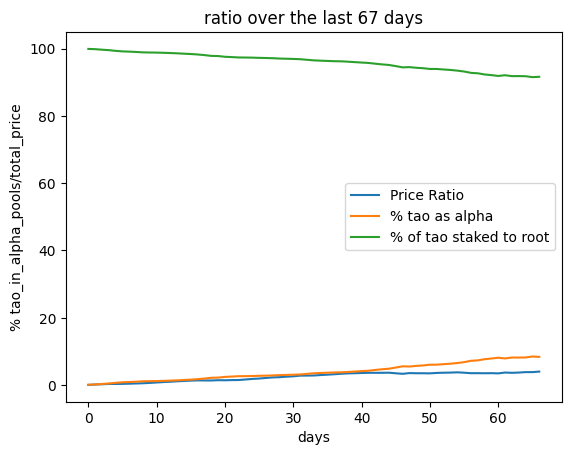

In [54]:
# Create a scatter plot
import matplotlib.pyplot as plt
plt.plot(range(len(price_ratio)), price_ratio, label='Price Ratio')
plt.plot(range(len(percent_tao_as_alpha)), percent_tao_as_alpha, label='% tao as alpha')

plt.plot(range(len(percent_tao_on_root)), percent_tao_on_root, label='% of tao staked to root')

# Add labels and title
plt.xlabel('days')
plt.ylabel('% tao_in_alpha_pools/total_price')
plt.title(f'ratio over the last {days} days')
# Add legend
plt.legend()
# Show the plot
plt.show()

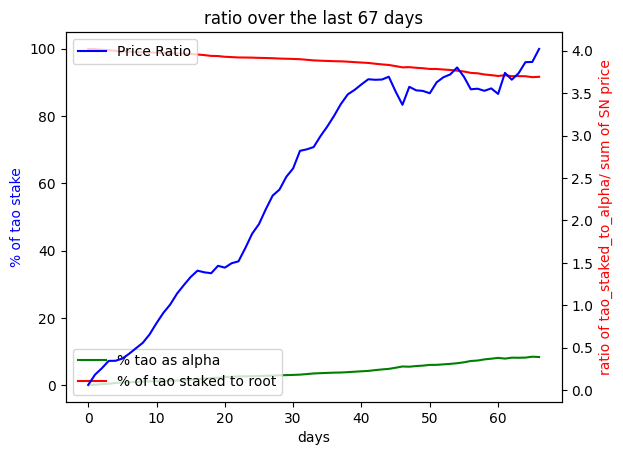

In [55]:
# Create the plot
fig, ax = plt.subplots()

# Plot price ratio and percent tao as alpha on the primary y-axis

ax.plot(range(len(percent_tao_as_alpha)), percent_tao_as_alpha, color = 'g',label='% tao as alpha')
ax.plot(range(len(percent_tao_on_root)), percent_tao_on_root, color = 'r', label='% of tao staked to root')
# Create a secondary y-axis
ax2 = ax.twinx()

# Plot percent tao on root on the secondary y-axis
ax2.plot(range(len(price_ratio)), price_ratio, color = 'b',label='Price Ratio')

# Add labels and title
ax.set_xlabel('days')
ax.set_ylabel('% of tao stake', color='b')
ax2.set_ylabel('ratio of tao_staked_to_alpha/ sum of SN price', color='r')

ax.set_title(f'ratio over the last {days} days')

# Add legend
ax.legend(loc='lower left')
ax2.legend(loc='upper left')

# Show the plot
plt.show()